# Setup

In [1]:
!pip install -Uqq fastbook fastai timm
import timm
from fastai.data.block import DataBlock
import fastbook

fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *



In [2]:
# all models
timm.list_models("convnext*")

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

In [3]:
# models with pre-trained weights
timm.list_models("convnext*", pretrained=True)

['convnext_atto.d2_in1k',
 'convnext_atto_ols.a2_in1k',
 'convnext_base.clip_laion2b',
 'convnext_base.clip_laion2b_augreg',
 'convnext_base.clip_laion2b_augreg_ft_in1k',
 'convnext_base.clip_laion2b_augreg_ft_in12k',
 'convnext_base.clip_laion2b_augreg_ft_in12k_in1k',
 'convnext_base.clip_laion2b_augreg_ft_in12k_in1k_384',
 'convnext_base.clip_laiona',
 'convnext_base.clip_laiona_320',
 'convnext_base.clip_laiona_augreg_320',
 'convnext_base.clip_laiona_augreg_ft_in1k_384',
 'convnext_base.fb_in1k',
 'convnext_base.fb_in22k',
 'convnext_base.fb_in22k_ft_in1k',
 'convnext_base.fb_in22k_ft_in1k_384',
 'convnext_femto.d1_in1k',
 'convnext_femto_ols.d1_in1k',
 'convnext_large.fb_in1k',
 'convnext_large.fb_in22k',
 'convnext_large.fb_in22k_ft_in1k',
 'convnext_large.fb_in22k_ft_in1k_384',
 'convnext_large_mlp.clip_laion2b_augreg',
 'convnext_large_mlp.clip_laion2b_augreg_ft_in1k',
 'convnext_large_mlp.clip_laion2b_augreg_ft_in1k_384',
 'convnext_large_mlp.clip_laion2b_augreg_ft_in12k_384',

In [4]:
# mode = resnet18
model = "convnextv2_tiny.fcmae_ft_in22k_in1k_384"

# Download Images

In [5]:
path = Path('/home/dant/data/not_pepper')
image_types = ['black dogs', 'dogs', 'cats', "black cats", "bears", "german shepherds", "mini bernedoodle",
               "wirehaired pointing griffon", "black mutts", "Cairn Terrier", "Scottish Terrier", "skye terrier",
               "Miniature Schnauzer", "Berger Picard", "irish wolfhound"]
if not path.exists():
    path.mkdir()

In [ ]:

for o in image_types:
    results = search_images_ddg(o)
    print(f"Dowloading images with description: {o}")
    download_images(path, urls=results)

print("Download complete")

# Cleanup

In [6]:
path = Path('/home/dant/data')
fns = get_image_files(path)
len(fns)

12867

In [7]:
failed = verify_images(fns)
len(failed)

0

In [8]:
failed.map(Path.unlink);


# Train

In [6]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.8), batch_tfms=aug_transforms())


In [7]:
dls = db.dataloaders(path)

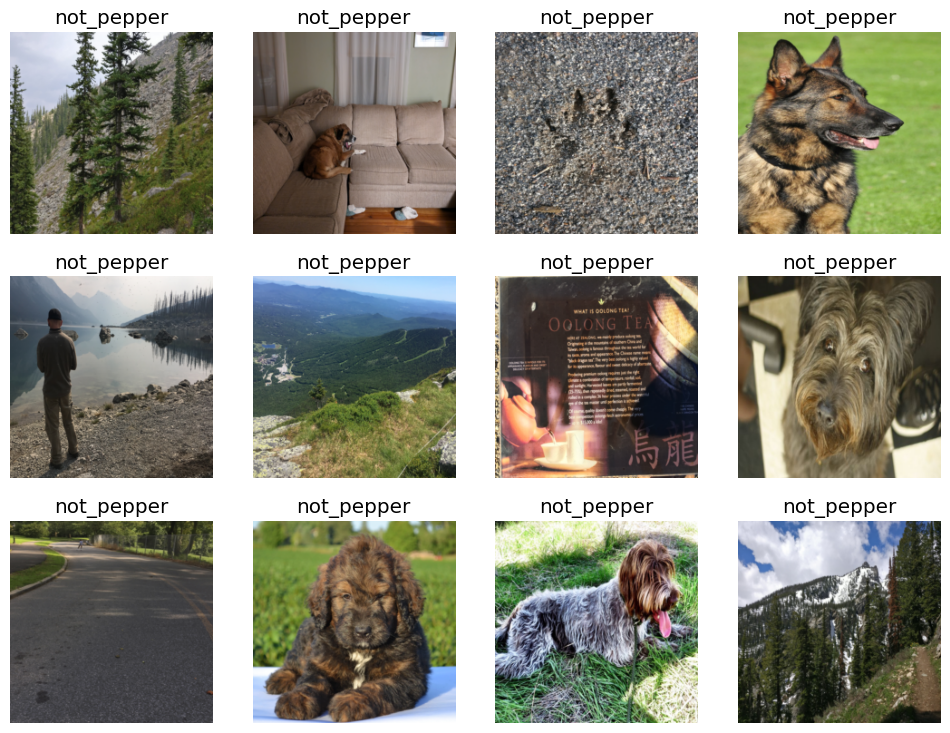

In [8]:

dls.valid.show_batch(max_n=12, nrows=3, unique=False)

In [9]:
learn = vision_learner(dls, model, metrics=error_rate)

In [10]:
learn.dls.vocab

['not_pepper']

In [11]:
learn.model

Sequential(
  (0): TimmBody(
    (model): ConvNeXt(
      (stem): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (stages): Sequential(
        (0): ConvNeXtStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): ConvNeXtBlock(
              (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (mlp): GlobalResponseNormMlp(
                (fc1): Linear(in_features=96, out_features=384, bias=True)
                (act): GELU()
                (drop1): Dropout(p=0.0, inplace=False)
                (grn): GlobalResponseNorm()
                (fc2): Linear(in_features=384, out_features=96, bias=True)
                (drop2): Dropout(p=0.0, inplace=False)
              )
              (shortcut): Identity()
              (drop_p

In [12]:
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time


/home/dant/.pyenv/versions/3.12.2/lib/python3.12/site-packages/fastai/learner.py:448: SyntaxWarning: invalid escape sequence '\R'
  e.args = [f"Custom classes or functions exported with your `Learner` not available in namespace.\Re-declare/import before loading:\n\t{e.args[0]}"]


KeyboardInterrupt: 

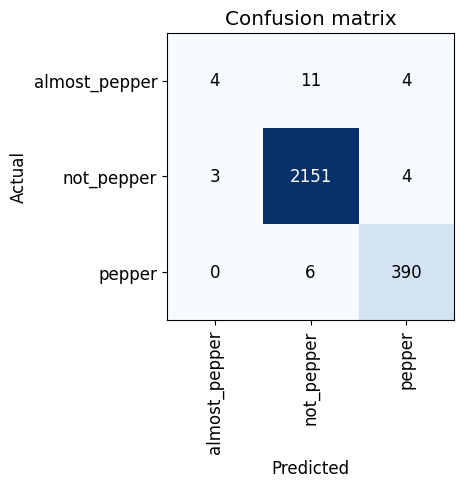

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

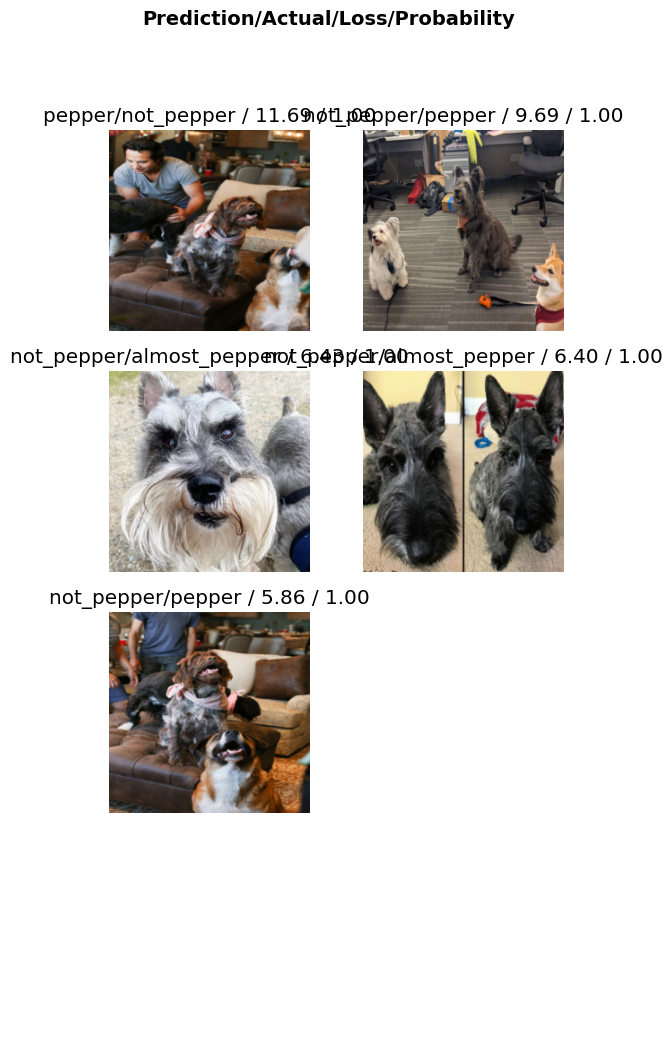

In [17]:
interp.plot_top_losses(5, nrows=4)


In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path / cat)

In [18]:
learn.export("/tmp/model.pkl")

# After Training

In [ ]:
#/export
from fastai.vision.all import *
import gradio as gr

learn = load_learner("/tmp/model.pkl")

In [ ]:
im = PILImage.create("images/dog1.jpg")
im.thumbnail((128, 128))
im

In [ ]:
learn.predict(im)

In [ ]:
#/export

def classify_image(img):
    pred, idx, prob = learn.predict(img)
    return dict(zip(learn.dls.vocab, map(float, prob)))


In [ ]:
classify_image(im)

In [ ]:
#/export
image = gr.Image(height=224, width=224)
label = gr.Label()

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label)
intf.launch(inline=False)